In [14]:
import re
import gc

import pandas as pd
import numpy as np
from tqdm import tqdm

import keras
from keras import losses, metrics, layers, ops

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [15]:
%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [16]:
train_df = pd.read_csv('data/train.csv')

In [17]:
train_set_df = train_df[['agent1', 'agent2', 'EnglishRules', 'LudRules']]

In [18]:
lud_preprocessor = layers.TextVectorization(
    vocabulary='ludii_tokens.dic',
    standardize='strip_punctuation'
)

eng_preprocessor = layers.TextVectorization(
    vocabulary='eng_tokens.dic'
)

max_eng = 0
max_lud = 0

eng_uniques = train_set_df['EnglishRules'].unique()

# for engrul in tqdm(eng_uniques):
#     eng_vector = eng_preprocessor(engrul)
#     max_eng = max(max_eng, eng_vector.shape[0])

# print(max_eng)


100%|██████████| 1328/1328 [00:05<00:00, 251.28it/s]

858


In [20]:
lud_uniques = train_set_df['LudRules'].unique()

EQPMNT_RE = r'\(equipment'
RULESTRIP_RE = r'[^a-zA-Z\(\)\{\}]'
DROP_RE = (r'\bVarName\b|\bto\b|\bif\b|\bsites\b|\bat\b|\bis\b|\bfrom\b|\bMover\b|\bcount\b|\blast\b'
           + r'|\bTo\b|\band\b|\bmove\b|\bwho\b')

for rule in tqdm(lud_uniques):
    start = re.search(EQPMNT_RE, rule).span()[0]
    pure_rule = rule[start:]
    pure_rule = re.sub(RULESTRIP_RE, ' ', pure_rule)
    pure_rule = re.sub(DROP_RE, '', pure_rule)
    lud_vector = lud_preprocessor(pure_rule)
    max_lud = max(max_lud, lud_vector.shape[0])

print(max_lud)

100%|██████████| 1373/1373 [00:05<00:00, 252.18it/s]

12904


In [7]:
agent1_uniques = train_set_df['agent1'].unique()
agent2_uniques = train_set_df['agent2'].unique()

set(agent1_uniques) >= set(agent2_uniques)

code_agent = {}
agent_code = {}

for id, agent in enumerate(agent1_uniques):
    code_agent[id] = agent
    agent_code[agent] = id


eng_vector.shape=(900,)

lud_vector.shape=(23716,)

agents_to_categorical.shape=(144)

In [8]:
# English rules LSTM features extractor.
# 
# Train set contains 384 preextracted features.
# Let`s assume that game rule contains these features and ather that describes 
# Number of these features is unknown and needs to be discovered
# presume that total amount of fetures, that are important for game result prediction is not less then double amount 
# of preextracted features and to be 800

FEATURES_NUM = 1024
ENG_DICT_LEN = 3692
ENG_VECTOR_DIM = 128
ENG_FILTERS_START = 4
ENG_RUL_KERNEL = 3

LUD_DICT_LEN = 1240
LUD_VECTOR_DIM = 128
LUD_FILTERS_START = 4
LUD_RUL_KERNEL = 7

In [9]:
class VectorNormalizer(keras.Layer):
    def __init__(self, dict_size: int) -> None:
        super().__init__()
        self.dict_size = dict_size

    def call(self, inputs):
        return inputs / self.dict_size


In [42]:
agents_len = 144
engvector_len = 900
ludvector_len = 4000

agent_input_layer = layers.Input(shape=(agents_len,), name='agent_input')

In [43]:
# EngRule Conv

engrul_input_layer = layers.Input(shape=(engvector_len, 1), name='engrul_input')
normalized = VectorNormalizer(ENG_DICT_LEN)(engrul_input_layer)
# block #1
eng_enter_conv = layers.Conv1D(filters=ENG_FILTERS_START,
                               kernel_size=ENG_RUL_KERNEL,
                               input_shape=(engvector_len, 1),
                               strides=2,
                               activation='relu',
                               name='eng_enter_conv')(normalized)
eng_block1_2 = layers.Conv1D(filters=ENG_FILTERS_START*2,
                             kernel_size=ENG_RUL_KERNEL,
                             activation='relu',
                             strides=2)(eng_enter_conv)

eng_block1_3 = layers.Conv1D(filters=ENG_FILTERS_START*4,
                             kernel_size=ENG_RUL_KERNEL,
                             activation='relu',
                             strides=2)(eng_block1_2)

eng_block1_4 = layers.Conv1D(filters=ENG_FILTERS_START*8,
                             kernel_size=ENG_RUL_KERNEL,
                             activation='relu',
                             strides=2)(eng_block1_3)

eng_block1_pool1 = layers.MaxPool1D(strides=2)(eng_block1_4)
eng_block1_flat = layers.Flatten()(eng_block1_pool1)

eng_batchnorm_block1 = layers.BatchNormalization()(eng_block1_flat)
eng_dense_block1 = layers.Dense(eng_batchnorm_block1.shape[1],
                                activation='relu')(eng_batchnorm_block1)

# bllock #2
eng_reshaped = layers.Reshape((eng_dense_block1.shape[1], 1))(eng_dense_block1)
eng_enter_block2 = layers.Conv1D(filters=ENG_FILTERS_START*2,
                                 kernel_size=ENG_RUL_KERNEL,
                                 strides=2,
                                 activation='relu')(eng_reshaped)

eng_block2_2 = layers.Conv1D(filters=ENG_FILTERS_START*4,
                             kernel_size=ENG_RUL_KERNEL,
                             strides=2,
                             activation='relu')(eng_enter_block2)

eng_block2_3 = layers.Conv1D(filters=ENG_FILTERS_START*8,
                             kernel_size=ENG_RUL_KERNEL,
                             strides=2,
                             activation='relu')(eng_block2_2)

eng_block2_4 = layers.Conv1D(filters=ENG_FILTERS_START*16,
                             kernel_size=ENG_RUL_KERNEL,
                             strides=2,
                             activation='relu')(eng_block2_3)

eng_block2_pool = layers.MaxPool1D(strides=2)(eng_block2_4)
eng_block2_flat = layers.Flatten()(eng_block2_pool)

eng_batchnorm_block2 = layers.BatchNormalization()(eng_block2_flat)
eng_dense_block2 = layers.Dense(eng_batchnorm_block2.shape[1],
                                activation='relu')(eng_batchnorm_block2)

eng_concat_block_1_2 = layers.Concatenate(axis=1)([eng_dense_block1, eng_dense_block2])
eng_out = layers.Dense(FEATURES_NUM, activation='relu')(eng_concat_block_1_2)

model = keras.Model(inputs=[engrul_input_layer], outputs=[eng_out], name="EngConv")

model.summary()

d:\miniconda3\envs\ds_atwork\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# LudRule Conv

ludrul_input_layer = layers.Input(shape=(ludvector_len, 1), name='ludrul_input')
normalized = VectorNormalizer(LUD_DICT_LEN)(ludrul_input_layer)
# block #1
lud_enter_conv = layers.Conv1D(filters=LUD_FILTERS_START,
                               kernel_size=LUD_RUL_KERNEL,
                               input_shape=(ludvector_len, 1),
                               strides=2,
                               activation='relu')(normalized)
lud_block1_2 = layers.Conv1D(filters=LUD_FILTERS_START*2,
                             kernel_size=LUD_RUL_KERNEL,
                             activation='relu',
                             strides=2)(lud_enter_conv)

lud_block1_3 = layers.Conv1D(filters=LUD_FILTERS_START*4,
                             kernel_size=LUD_RUL_KERNEL,
                             activation='relu',
                             strides=2)(lud_block1_2)

lud_block1_4 = layers.Conv1D(filters=LUD_FILTERS_START*8,
                             kernel_size=LUD_RUL_KERNEL,
                             activation='relu',
                             strides=2)(lud_block1_3)

lud_block1_pool1 = layers.MaxPool1D(strides=2)(lud_block1_4)
lud_block1_flat = layers.Flatten()(lud_block1_pool1)

lud_batchnorm_block1 = layers.BatchNormalization()(lud_block1_flat)
lud_dense_block1 = layers.Dense(lud_batchnorm_block1.shape[1],
                                activation='relu')(eng_batchnorm_block1)

# bllock #2
lud_reshaped = layers.Reshape((lud_dense_block1.shape[1], 1))(lud_dense_block1)
lud_enter_block2 = layers.Conv1D(filters=LUD_FILTERS_START*2,
                                 kernel_size=LUD_RUL_KERNEL,
                                 strides=2,
                                 activation='relu')(lud_reshaped)

lud_block2_2 = layers.Conv1D(filters=LUD_FILTERS_START*4,
                             kernel_size=LUD_RUL_KERNEL,
                             strides=2,
                             activation='relu')(lud_enter_block2)

lud_block2_3 = layers.Conv1D(filters=LUD_FILTERS_START*8,
                             kernel_size=LUD_RUL_KERNEL,
                             strides=2,
                             activation='relu')(lud_block2_2)

lud_block2_4 = layers.Conv1D(filters=LUD_FILTERS_START*16,
                             kernel_size=LUD_RUL_KERNEL,
                             strides=2,
                             activation='relu')(lud_block2_3)

lud_block2_pool = layers.MaxPool1D(strides=2)(lud_block2_4)
lud_block2_flat = layers.Flatten()(lud_block2_pool)

lud_batchnorm_block2 = layers.BatchNormalization()(lud_block2_flat)
lud_dense_block2 = layers.Dense(lud_batchnorm_block2.shape[1],
                                activation='relu')(lud_batchnorm_block2)

lud_concat_block_1_2 = layers.Concatenate(axis=1)([lud_dense_block1, lud_dense_block2])
lud_out = layers.Dense(FEATURES_NUM, activation='relu')(lud_concat_block_1_2)


In [31]:

model = keras.Model(inputs=[ludrul_input_layer], outputs=[lud_out])

# model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ engrul_input        │ (None, 900, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vector_normalizer   │ (None, 900, 1)    │          0 │ engrul_input[0][… │
│ (VectorNormalizer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 449, 4)    │         16 │ vector_normalize… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 224, 8)    │        104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 111, 16)   │        400 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 55, 32)    │      1,568 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 27, 32)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 864)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 864)       │      3,456 │ flatten[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3904)      │  3,376,960 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 3904, 1)   │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 1949, 8)   │         64 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 972, 16)   │        912 │ conv1d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 483, 32)   │      3,616 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 239, 64)   │     14,400 │ conv1d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 119, 64)   │          0 │ conv1d_47[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 7616)      │          0 │ max_pooling1d_11… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7616)      │     30,464 │ flatten_11[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 7616)      │ 58,011,072 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 11520)     │          0 │ dense_15[0][0],   │
│ (Concatenate)       │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ludrul_input        │ (None, 4000, 1)   │          0 │ -               

 Total params: 73,240,536 (279.39 MB)

 Trainable params: 73,223,576 (279.33 MB)

 Non-trainable params: 16,960 (66.25 KB)

In [44]:
assemble = layers.Concatenate(axis=1)([agent_input_layer, eng_out, lud_out])
x = layers.Dense(1024, activation='relu')(assemble)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='tanh')(x)

model = keras.Model(inputs=[agent_input_layer, engrul_input_layer, ludrul_input_layer],
                    outputs=[out])


ValueError: The name "engrul_input" is used 2 times in the model. All operation names should be unique.

In [33]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ engrul_input        │ (None, 900, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vector_normalizer   │ (None, 900, 1)    │          0 │ engrul_input[0][… │
│ (VectorNormalizer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 449, 4)    │         16 │ vector_normalize… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 224, 8)    │        104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 111, 16)   │        400 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 55, 32)    │      1,568 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 27, 32)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 864)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 864)       │      3,456 │ flatten[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 864)       │    747,360 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3904)      │  3,376,960 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 864, 1)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 3904, 1)   │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 431, 8)    │         32 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 1949, 8)   │         64 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 215, 16)   │        400 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 972, 16)   │        912 │ conv1d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 107, 32)   │      1,568 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 483, 32)   │      3,616 │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 53, 64)    │      6,208 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 239, 64)   │     14,400 │ conv1d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 26, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 82,265,033 (313.82 MB)

 Trainable params: 82,244,745 (313.74 MB)

 Non-trainable params: 20,288 (79.25 KB)

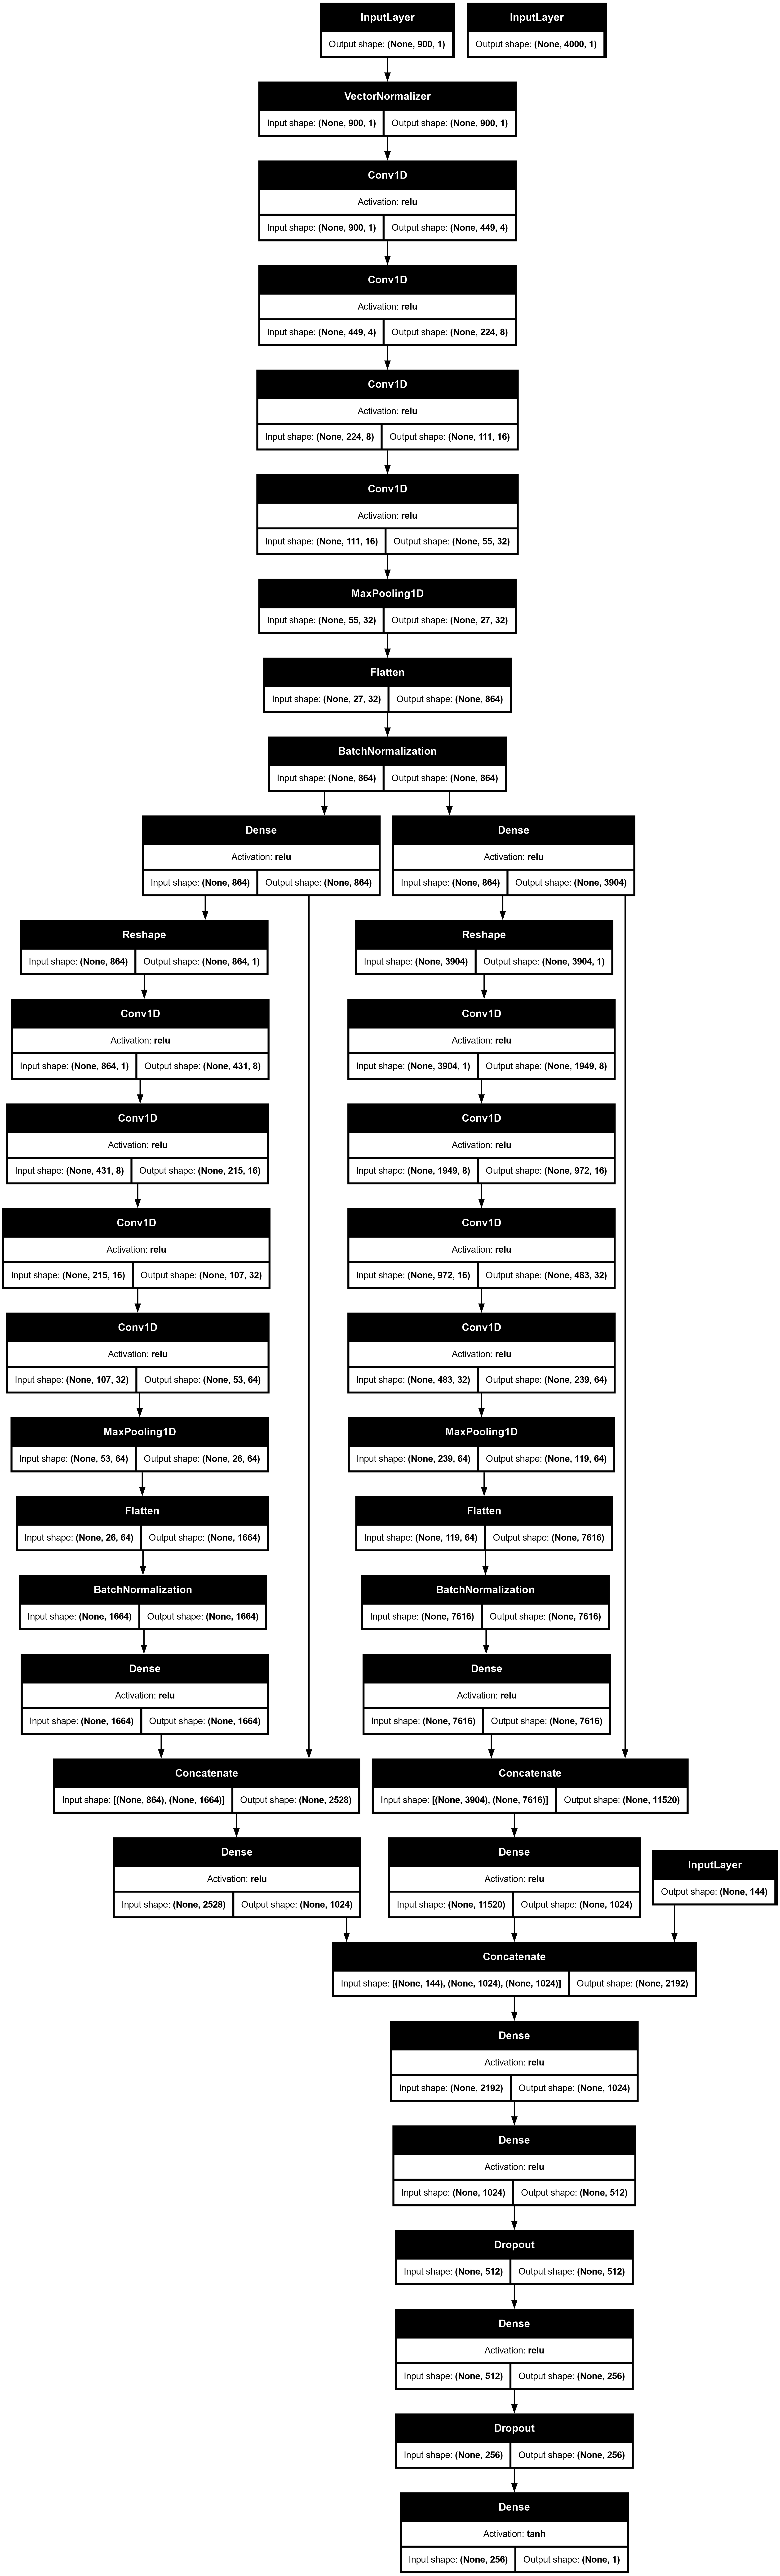

In [46]:
keras.utils.plot_model(model,
                       show_shapes=True,
                       expand_nested=True,
                       show_layer_activations=True)

## DataGenerator

In [34]:

class GameDataGenerator(keras.utils.Sequence):
    eqpmnt_re = r'\(equipment'
    rulestrip_re = r'[^a-zA-Z\(\)\{\}]'
    engvector_len = 900
    ludvector_len = 23700
    
    def __init__(self, list_IDs, dataframe, labels_dict, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.labels_dict = labels_dict
        self.df = dataframe[['agent1', 'agent2', 'EnglishRules', 'LudRules']]
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.list_IDs))
        self._agent_code = agent_code
    
    @property
    def agent_code(self):
        return self._agent_code

    @agent_code.setter
    def agent_code(self):
        agents = self.df['agent1'].unique().tolist()
        agents.sort()
        ret = {}
        for id_, agent in enumerate(agents):
            ret[agent] = id_
        self._agent_code = ret

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, batch_num):
          # Generate indexes of the batch
        indexes = self.indexes[batch_num*self.batch_size:(batch_num+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_ends(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def _lud_prepare(self, rule) -> str:
        start = re.search(self.eqpmnt_re, rule).span()[0]
        pure_rule = rule[start:]
        pure_rule = re.sub(self.rulestrip_re, ' ', pure_rule)
        return pure_rule

    def __data_generation(self, list_IDs_temp):
        X_agents = []
        X_engvectors = []
        X_ludvectors = []
        y = []

        agents_num = len(self.agent_code)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            row = self.df.loc[ID]
            agent1, agent2, engrul, ludrul = row

            y.append(self.labels_dict[ID])

            agent1_encoded = keras.utils.to_categorical(self.agent_code[agent1], agents_num)
            agent2_encoded = keras.utils.to_categorical(self.agent_code[agent2], agents_num)
            agents_encoded = np.hstack((agent1_encoded, agent2_encoded))
            X_agents.append(np.array(agents_encoded))

            engrul_vector = eng_preprocessor(engrul)
            engrul_vector = keras.utils.pad_sequences((engrul_vector,), maxlen=self.engvector_len)
            X_engvectors.append(engrul_vector)

            ludrul_vector = lud_preprocessor(self._lud_prepare(ludrul))
            ludrul_vector = keras.utils.pad_sequences((ludrul_vector,), maxlen=self.ludvector_len)
            X_ludvectors.append(ludrul_vector)

        return (np.array(X_agents), np.array(X_engvectors), np.array(X_ludvectors)), np.array(y)

In [35]:
train_shuffled_df = shuffle(train_df)

labels = train_shuffled_df['utility_agent1'].to_dict()

X_train, X_test = train_test_split(train_shuffled_df, test_size=0.25)

In [17]:
X_train.index

Index([220178,  22006, 135444, 159326, 104611,  64210,  16923,   9198, 117723,
       220468,
       ...
         5131,   3621,  12832,  68695, 198282, 213114,  99701,  41744,  25523,
        22318],
      dtype='int64', length=174925)

In [36]:
BATCH_SIZE = 2

In [37]:
train_generator = GameDataGenerator(X_train.index, train_shuffled_df, labels, batch_size=BATCH_SIZE)
test_generator = GameDataGenerator(X_test.index, train_shuffled_df, labels, batch_size=BATCH_SIZE)

In [38]:
model.compile(optimizer='adam',
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanSquaredError()]
              )

In [39]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [45]:
keras.backend.clear_session()
gc.collect()

checkpoint = keras.callbacks.ModelCheckpoint(
    monitor='val_mean_squared_error',
    save_best_only=True,
    filepath='lstm_both_epoch{epoch:02d}_val_{val_mean_squared_error:0.4f}.keras'
)

history = model.fit(
    x=train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1,
	callbacks=[checkpoint])

Epoch 1/10


ValueError: Input 1 of layer "functional_4" is incompatible with the layer: expected shape=(None, 900, 1), found shape=(None, 1, 900)